In [1]:
import glob, json
import numpy as np
import pandas as pd
from scipy.stats import entropy
import sklearn.decomposition
import sklearn.manifold
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append('..')

from lib import *

In [2]:
proteome = 'Humanviruses'
k = 9
all_data = {}
for i, model in enumerate(['independent', 'ncov', 'nskew', 'nskewfcov']):

    arr = np.load('../classifier/data/{proteome}_{model}_k{k}_likelihoods.npz'.format(proteome=proteome,
                                                                                      model=model, k=k))
    df = pd.read_csv('../maxent/data/{proteome}_{model}_k{k}_dkl.csv'.format(proteome=proteome,
                                                                             model=model, k=k),
                     index_col=0, squeeze=True)
    dkl = df.loc['DKL']
    data = {}

    logp_hh, logp_pp, logp_hp, logp_ph = arr['logp_hh'], arr['logp_pp'], arr['logp_hp'], arr['logp_ph']
    data['logp_hh'], data['logp_pp'], data['logp_hp'], data['logp_ph'] = logp_hh, logp_pp, logp_hp, logp_ph

    positive = logp_pp-logp_ph
    negative = logp_hp-logp_hh
    data['positive'] = np.sort(positive)*np.log10(np.exp(1))
    data['negative'] = np.sort(negative)*np.log10(np.exp(1))
    data['dkl'] = dkl
    
    all_data[model] = data

In [3]:
human_kmers = load_matrix('../maxent/data/Human_test_k{k}_matrix.csv.gz'.format(k=k))
pathogen_kmers = load_matrix('../maxent/data/{proteome}_test_k{k}_matrix.csv.gz'.format(proteome=proteome, k=k))

In [4]:
human_kmers_str = matrix_to_kmers(human_kmers)

In [5]:
pathogen_kmers_str = matrix_to_kmers(pathogen_kmers)

In [6]:
with open('data/human.txt', 'w') as f:
    for item in human_kmers_str[:10000]:
        f.write("%s\n" % item)

In [7]:
with open('data/pathogen.txt', 'w') as f:
    for item in pathogen_kmers_str[:10000]:
        f.write("%s\n" % item)

In [8]:
from lib.netmhcrunutils import run_netMHC

In [9]:
dfhla = pd.read_csv(datadir+'hlas.csv', sep='\t', skiprows=1)
dfhla['name']

0     HLA-A0101
1     HLA-A0201
2     HLA-A0202
3     HLA-A0203
4     HLA-A0205
        ...    
76    HLA-C0802
77    HLA-C1203
78    HLA-C1402
79    HLA-C1502
80    HLA-E0101
Name: name, Length: 81, dtype: object

In [10]:
for hla in dfhla['name']:
    run_netMHC('data/human.txt', 'data/human', hla, binder_only=False)

In [11]:
for hla in dfhla['name']:
    run_netMHC('data/pathogen.txt', 'data/pathogen', hla, binder_only=False)

In [12]:
proteome = 'Humanviruses'
model = 'nskewfcov'
arr = np.load('../classifier/data/{proteome}_{model}_k{k}_likelihoods.npz'.format(proteome=proteome,
                                                                                      model=model, k=k))
prob_ratio_pathogen = (arr['logp_pp'] - arr['logp_ph'])[:10000]
prob_ratio_human = (arr['logp_hp'] - arr['logp_hh'])[:10000]
prob_pathogen = arr['logp_pp'][:10000]
prob_human = arr['logp_hh'][:10000]

In [13]:
proteome = 'pathogen'
correlations_pathogen = []
correlations_pathogen_ratio = []
for hla in dfhla['name']:
    df = pd.read_csv('data/{proteome}-{hla}.csv'.format(proteome=proteome, hla=hla), sep='\t', skiprows=1)
    corr, pval = scipy.stats.spearmanr(prob_pathogen, np.array(df['nM']))
    correlations_pathogen.append(corr)
    corr, pval = scipy.stats.spearmanr(prob_ratio_pathogen, np.array(df['nM']))
    correlations_pathogen_ratio.append(corr)

In [14]:
proteome = 'human'
correlations_human = []
correlations_human_ratio = []
for hla in dfhla['name']:
    df = pd.read_csv('data/{proteome}-{hla}.csv'.format(proteome=proteome, hla=hla), sep='\t', skiprows=1)
    corr, pval = scipy.stats.spearmanr(prob_human, np.array(df['nM']))
    correlations_human.append(corr)
    corr, pval = scipy.stats.spearmanr(prob_ratio_human, np.array(df['nM']))
    correlations_human_ratio.append(corr)

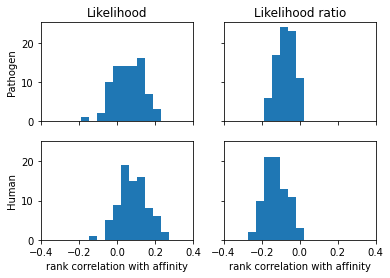

In [20]:
fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True)
bins = np.linspace(-0.4, 0.4, 20)
axes[0, 0].hist(correlations_pathogen, bins=bins)
axes[0, 0].set_ylabel('Pathogen')
axes[0, 0].set_title('Likelihood')
axes[0, 1].hist(correlations_pathogen_ratio, bins=bins)
axes[0, 1].set_title('Likelihood ratio')
axes[1, 0].hist(correlations_human, bins=bins)
axes[1, 0].set_ylabel('Human')
axes[1, 1].hist(correlations_human_ratio, bins=bins)
axes[0, 0].set_xlim(min(bins), max(bins))
axes[1, 0].set_xlabel('rank correlation with affinity')
axes[1, 1].set_xlabel('rank correlation with affinity')
fig.savefig('netmhc_correlations.pdf')

<AxesSubplot:>

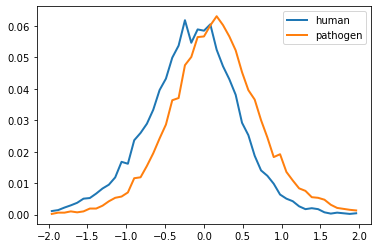

In [17]:
fig, ax = plt.subplots()
plot_histograms([prob_ratio_human, prob_ratio_pathogen],
                ['human', 'pathogen'],
                nbins=50, lw=2,
                xmin=-2, xmax=2, ax=ax, step=False)

In [ ]:
background = np.mean(prob_ratio) - np.mean(prob_ratio_human)

In [ ]:
dkls = []
ratios = []
for hla in dfhla['name']:
    dfs = {}
    for proteome in ['human', 'pathogen']:
        df = pd.read_csv('data/{proteome}-{hla}.csv'.format(proteome=proteome, hla=hla), sep='\t', skiprows=1)
        dfs[proteome] = df
    ratio = np.sum(dfs['pathogen']['Rank'] < 10)/np.sum(dfs['human']['Rank'] < 10)
    ratios.append(ratio)
    dkl = np.mean(prob_ratio[dfs['pathogen']['Rank'] < 1]) - np.mean(prob_ratio_human[dfs['human']['Rank'] < 1])
    dkls.append(dkl)
    #print(hla, dkl, dp)

In [ ]:
plt.hist(dkls)
plt.axvline(background, color='k');

In [ ]:
plt.hist(np.log2(ratios))
top_ratio = all_data['nskewfcov']['positive']
top_ratio = np.mean(neg_ratio[-int(0.1*len(neg_ratio)):])/np.log(2)
plt.axvline(top_ratio)

In [ ]:
proteome = 'Humanviruses'
data = {}
for model in ['independent', 'nskewfcov']:
    arr = np.load('../classifier/data/{proteome}_{model}_k{k}_likelihoods.npz'.format(proteome=proteome,
                                                                                      model=model, k=k))
    data[model] = arr['logp_hh']

In [ ]:
density_scatter(data['independent'], data['nskewfcov'])

In [ ]:
scipy.stats.spearmanr(data['independent'], data['nskewfcov'])